In [1]:
%cd ..

/seda_s2anet


In [2]:
%ls

20230827_214946.log  README.md    model_store/   s2anet/
20230827_231648.log  command.txt  notebook_tfm/  s2anet.yml
20230827_233109.log  demo.py*     notebooks/     utils.py*
20230827_235232.log  docker/      ray/           work_dirs/


In [ ]:
# specify device
device = 'cuda:0'

%run s2anet/tools/train.py notebook_tfm/train_config.py 

In [4]:
def get_tiles(ds, width=1000, height=1000):
    ncols, nrows = ds.meta['width'], ds.meta['height']

    cociente_x = ncols // width
    cociente_y = nrows // height
    resto_x = ncols % width
    resto_y = nrows % height

    if resto_x > 0:
        ncols = cociente_x * width + width
    else:
        ncols = ncols

    if resto_y > 0:
        nrows = cociente_y * height + height
    else:
        nrows = nrows

    offsets = product_iter(range(0, ncols, width), range(0, nrows, height))
    big_window = rio.windows.Window.from_slices(rows=(0,nrows), cols=(0,ncols), width=width, height=height, boundless=True)
    for col_off, row_off in  offsets:
        window = rio.windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = rio.windows.transform(window, ds.transform)
        yield window, transform
        
def BGR2RGB(im_batch):
    #return im_batch[...,::-1]
    return np.array([cv2.cvtColor(im, cv2.COLOR_RGB2BGR) for im in im_batch])


# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    boxes = np.array(boxes)
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(area)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return pick


def get_corners_and_hbb(resultado_predict, original_height=1080, original_width=1920):
    """ 
        Dado un obb en formato (cx, cy, h, w, ang) devuelve los 4 vertices del rectangulo orientado
        y el HBB tambien, para futuro en data-processing.
    """
    corners = []
    hbbs = []

    for res in resultado_predict:
        center_x = res[0]
        center_y = res[1]
        h = res[3]
        w = res[2]
        ang = res[4]

        ang_grad = (ang * 180) / np.pi
        ang_rad = ang
        ang_rad_1 = ( - ang_rad + np.pi/2)
        ang_rad_2 = (ang_rad_1 + np.pi/2)
        
        xmax = int(center_x + h/2 * np.cos(ang_rad_1) + w/2 * np.cos(ang_rad_2))
        ymax = int(center_y - h/2 * np.sin(ang_rad_1) - w/2 * np.sin(ang_rad_2))
        mbox_w = w
        mbox_h = h

        rotation = ang_grad
        corner_1_x = xmax
        corner_1_y = ymax
        corner_2_x = corner_1_x+mbox_w*np.cos(np.radians(rotation))
        corner_2_y = corner_1_y+mbox_w*np.sin(np.radians(rotation))
        corner_3_x = corner_2_x-mbox_h*np.cos(np.radians(rotation)-np.pi/2)
        corner_3_y = corner_2_y-mbox_h*np.sin(np.radians(rotation)-np.pi/2)
        corner_4_x = corner_1_x-mbox_h*np.cos(np.radians(rotation)-np.pi/2)
        corner_4_y = corner_1_y-mbox_h*np.sin(np.radians(rotation)-np.pi/2)

        corner = [corner_1_x, corner_1_y, corner_2_x, corner_2_y, corner_3_x, corner_3_y,corner_4_x, corner_4_y]
        corners.append(corner)

        # hbb from obb
        x_min = min(corner_1_x, corner_2_x, corner_3_x, corner_4_x)
        y_min = min(corner_1_y, corner_2_y, corner_3_y, corner_4_y)
        x_max = max(corner_1_x, corner_2_x, corner_3_x, corner_4_x)
        y_max = max(corner_1_y, corner_2_y, corner_3_y, corner_4_y)

        # hbb = [x_min, y_min, x_max, y_max]
        hbb = [max(0, y_min), max(0, x_min), min(original_height, y_max), min(original_width, x_max) ]
        # hbb = [y_min, x_min, y_max, x_max ]
        hbbs.append(hbb)

    return corners, hbbs

In [2]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot, show_result
from mmcv import Config
from utils import build_dataset, show_result_rbox

import sys
import matplotlib.pyplot as plt
import numpy as np
import mmcv
import cv2

import matplotlib.pyplot as plt
from PIL import Image
import rasterio as rio
from itertools import product as product_iter
from math import ceil
import torch
import torchvision
import math

sys.path.append("..")

iou_threshold = 0.70
threshold = 0.3

In [3]:
# specify device
device = 'cuda:0'

# retrained 2 times on hrsc2021_dota adding albumentations Downscale
# config_file = '../s2anet/configs/hrsc2021/cascade_s2anet_2s_r50_fpn_3x_hrsc2021_dota_v10.py'
# checkpoint_file = '../work_dirs/cascade_s2anet_2s_r50_fpn_3x_hrsc2021_dota_v10/epoch_36.pth'
# checkpoint_file = '../model_store/cascade_s2anet_2s_r50_fpn_3x_hrsc2016-3d00fee5.pth'
config_file = 'train_config.py'
checkpoint_file = '../work_dirs/train_config/epoch_36.pth'

# init a detector
model = init_detector(config_file, checkpoint_file, device=device)

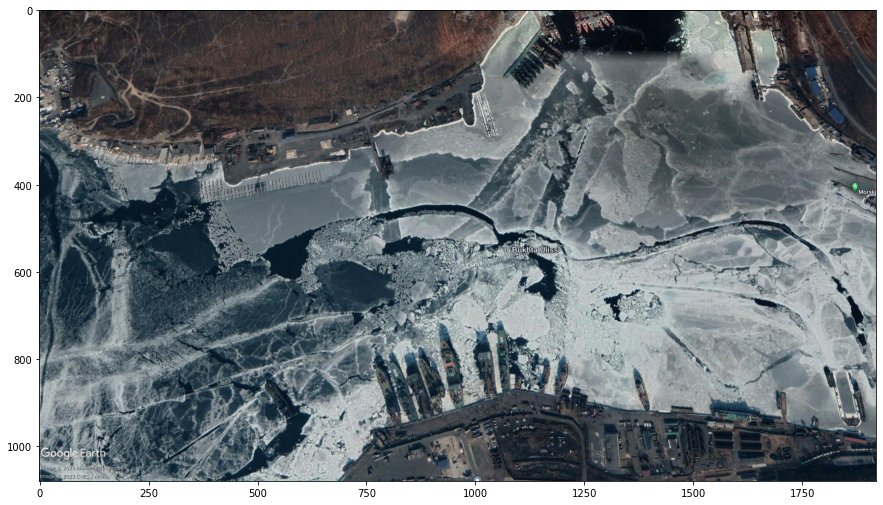

(1080, 1920, 3)

In [5]:
im_frozen = 'images/ice_2_2019_1250.jpg'
im_path = im_frozen
im = plt.imread(im_path)
plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()
im.shape

In [6]:
im_batch = []
im_off = []
num_divisions = 7
for n in range(1,num_divisions):
    tile_width, tile_height = 2048//n, 2048//n
    im_path = im_frozen
    number_tile = 0
    with rio.open(im_path) as inds:
        n_w = ceil(inds.shape[0] / tile_width)
        n_h = ceil(inds.shape[1] / tile_height)
        order = [i+j*n_h for i in range(1, n_h+1) for j in range(n_w)]
        for window, transform in get_tiles(inds, tile_width, tile_height):
            im = inds.read(window=window, boundless=True)
            im = np.moveaxis(im, 0, -1)
            im = im[:, :, :3]
            im_batch.append(im)
            im_off.append([window.col_off, window.row_off])
            number_tile += 1
            
im_batch = np.array(im_batch)
im_off = np.array(im_off)

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
im_batch = BGR2RGB(im_batch)   
dets_all = []
dets_global = []

for im in im_batch:
    dets  = inference_detector(model, im)[0]
    d_copy = np.copy(dets)
    dets_all.append(dets)
    dets_global.append(d_copy)

for i in range(len(dets_global)):
    dets_global[i][:,0] = dets_global[i][:,0] + im_off[i][0]
    dets_global[i][:,1] = dets_global[i][:,1] + im_off[i][1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Detección

Como ya hemos mencionado en el caso de Rota el número de detecciones mejora al emplear recortes de distintos tamaños.


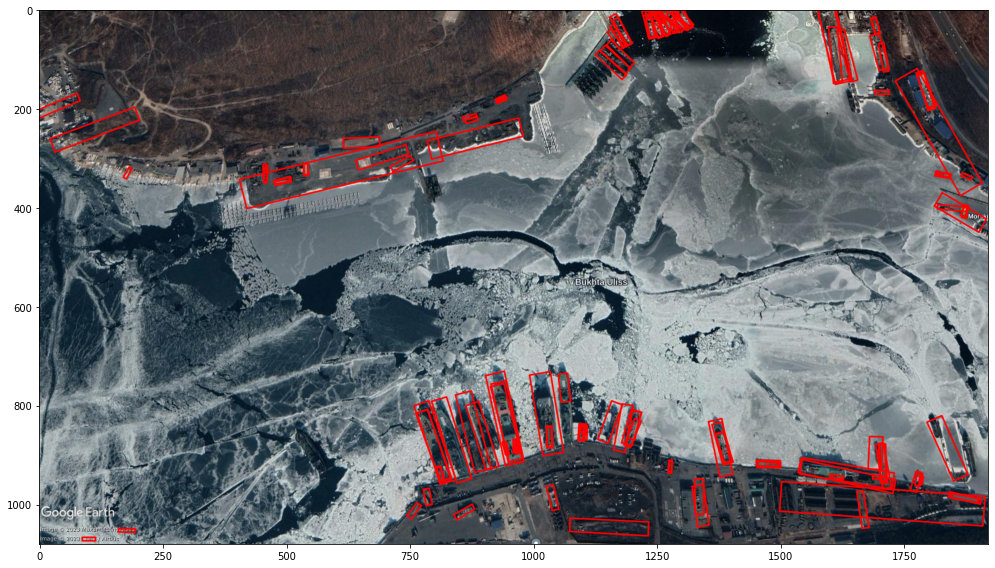

In [8]:
#threshold = 0.3
im_path = im_frozen
im = cv2.imread(im_path)
plt.figure(figsize=(17,17))
im_ = im.copy()


for det_g, off in zip(dets_global, im_off):
    im_ = show_result_rbox(im_, [det_g], class_names=["ship"], threshold=threshold, colormap=[(0,0,255)])
    
im_ = cv2.cvtColor(im_, cv2.COLOR_RGB2BGR)
plt.imshow(im_)
plt.show()

In [9]:
#dets_global[0]

#iou_threshold = 0.9

#cx,cy,w,h,ánglulos
param = [det[:,:-1] for det in dets_global if 0 not in det.shape]
#socres
scores = [det[:,-1] for det in dets_global if 0 not in det.shape]
#angulos
ang = [det[:,-2] for det in dets_global if 0 not in det.shape]

param = np.vstack(param)
scores = np.concatenate(scores)
ang = np.concatenate(ang)

p_aux = []
s_aux = []
a_aux = []

#seleccionamos unicamente las detecciones que tienen un score mayor que nuestro threshold
for p,s,a in zip(param, scores, ang):
    if s > threshold:
        p_aux.append(p)
        s_aux.append(s)
        a_aux.append(a)
        
param = np.array(p_aux[:])
scores = np.array(s_aux[:])
ang = np.array(a_aux[:])
        


# pasamos de radianes a grados
param = [ [p[0], p[1], p[2], p[3], math.degrees(p[4])] for p in param ]
param2 = [ [p[0], p[1], p[2], p[3], math.radians(p[4])] for p in param ]

#pasamos las cajas detecciones de formato cx,cy,w,h a x1,y1,x2,y2 para poder utilizar la función de non-max supression
bboxes = [ [p[0]-(p[2]//2), p[1]-(p[3]//2), p[0]+(p[2]//2), p[1]+(p[3]//2)] for p in param]
#generamos una lista con las detecciones como cajas cuadradas para poder utilizar la funcion de non-max supression
#bboxes_cuadrados = [ [p[0]-(p[2]//2), p[1]-(p[2]//2), p[0]+(p[2]//2), p[1]+(p[2]//2)] for p in param]
_, bboxes_cuadrados = get_corners_and_hbb(param2, 2048, 2048)
bboxes = np.array(bboxes, dtype=np.float32)

#obtenemos una lista con los índices de las cajas validas según la función de non-max supression
idx = non_max_suppression_fast(bboxes_cuadrados, iou_threshold)

#filtramos nuestras bboxes, angulos y scores usando los índices de las bboxes definitivas
bboxes_filtered = [bboxes[i] for i in idx]
scores_filtered = [scores[i] for i in idx]
ang_filtered = [ang[i] for i in idx]

#unificamos las listas de bboxes, scores y ángulos
bboxes_filtered = [[f[0],f[1],f[2],f[3],a, s] for f,s,a in zip(bboxes_filtered, scores_filtered, ang_filtered)]

#volvemos a pasar de formato x1,y1,x2,y2,ángulo,score a cx,cy,w,h,ángulo,score
bboxes_filtered_2 = [ [ f[0]+((f[2]-f[0])//2), f[1]+((f[3]-f[1])//2), (f[2]-f[0]), (f[3]-f[1]), f[4], f[5] ] for f in bboxes_filtered]

### Vista de las cajas a las que se le aplica el non-max supression

Estas cajas se utilizan unicamente para aplicar non-max supression y conocer el índice de las cajas definitivas, las cuales no son cuadradas.

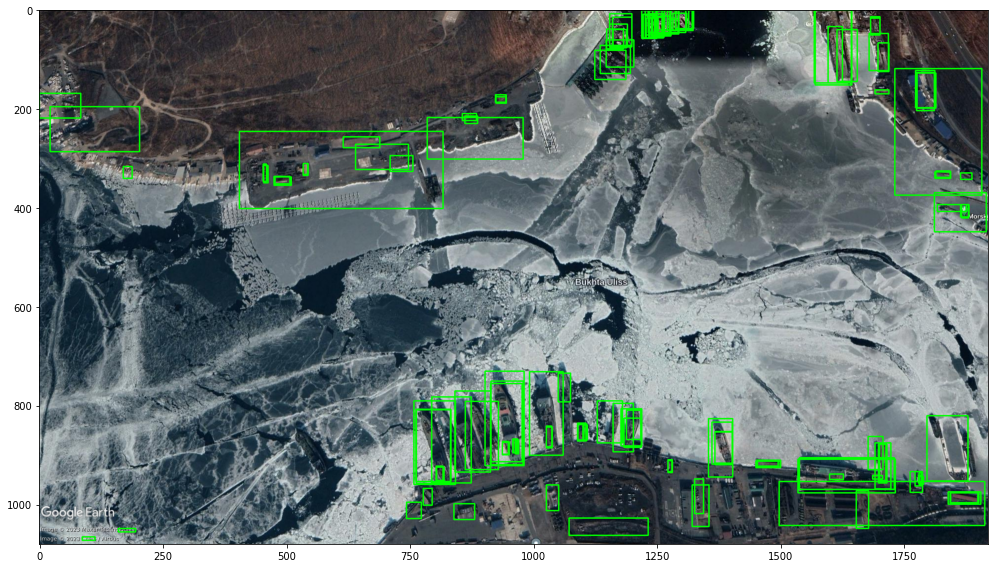

In [10]:
im_path = im_frozen
im = cv2.imread(im_path)
plt.figure(figsize=(17,17))
im_ = im.copy()

for b, s in zip(bboxes_cuadrados, scores):
    if s > threshold:
        im_ = cv2.rectangle(im_, (int(b[1]),int(b[0])), (int(b[3]),int(b[2])), (0,255,0), 2)
im_ = cv2.cvtColor(im_, cv2.COLOR_RGB2BGR)
plt.imshow(im_)
plt.show()

### Resultado

Cajas de detección definitivas.

Como se puede observar ahora únicamente se cuenta con una única caja por buque.


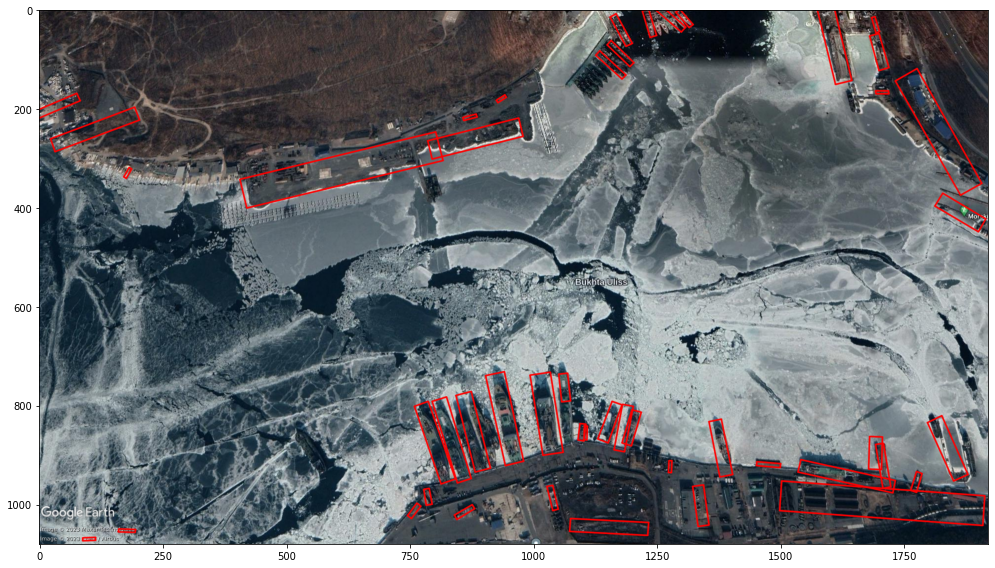

In [11]:
im_path = im_frozen
im = cv2.imread(im_path)
plt.figure(figsize=(17,17))
im_ = im.copy()

im_ = show_result_rbox(im_, [bboxes_filtered_2], class_names=["ship"], threshold=threshold, colormap=[(0,0,255)])
im_ = cv2.cvtColor(im_, cv2.COLOR_RGB2BGR)
plt.imshow(im_)
plt.show()